# Polyphase Filter Bank Timing Synchronisation

In [1]:
%load_ext autoreload
%autoreload 2
#%pylab inline
#%matplotlib notebook
import sys
import pprint
sys.path.append('../library')
import numpy as np
import matplotlib.pyplot as plt
import control
from fir_filter import FIRFilter
from generic_modem import GenericModem
from timing_sync_polyphase import TimingSyncPolyphase
from utilities import phase_shift

### Overview
The Timing Synchroniser will use the topology proposed in Fred Harris' _'Multirate Digital Filters for Symbol Timing Synchronization in Software Defined Radios'_ Paper.

The general concept is to combine the matched filtering and timing synchronisation interpolation within a single structure. By using $M$ filter banks with fractional sample delays different delays can be achieved to select the most appropriate phase achieving an accuracy of $1/M$.

### Matched Filter Bank

#### Filter Structure
For algorithm development $M$ parallel matched filters are created in Python. Each filter output can be then be selected. 

For hardware development it is intended that a single filter structure is used with the coefficients selectively applied depending on the selected filter phase.

#### Timing Error Detector
The maximum likelihood (ML) timing error detector (TED) is used.
The ML TED if defined as:

$$ \frac{d}{d \tau} = \sum_k tanh \left( \frac{2 E}{N_0} y(kT + \tau) \right) \frac{d}{d \tau} y(kT+\tau)=0 $$

where $y(kT+\tau$ is the output of the matched filter output.

Next we can consider this mathematical expression in terms of signal processing blocks. 
Firstly, there is a matched filter ($y(kT + \tau) $) and another filter with the derivative of the matched filter coefficients ($\frac{d}{d \tau} y(kT+\tau)$).

There is a $tanh(\frac{2E}{N_0}...)$ term around the matched filter. We consider the two limits of the SNR 
($\frac{2E}{N_0}$).
1. When $tanh\left(\frac{E_b}{N_0} \cdot y(t)\right) \rightarrow y(t) ~~~ as ~~ \frac{E_b}{N_0} \rightarrow 0 $
So the $tanh(\frac{2E}{N_0}...)$ expression can simply be ignored and the output of the matched filter can be used directly.
2. When $ tanh\left(\frac{E_b}{N_0} \cdot y(t)\right) \rightarrow sgn\left(y(t)\right) ~~~ as ~~ \frac{E_b}{N_0} \rightarrow \infty $ so the expression can be approximated by $sgn()$ of the matched filter output.

In [51]:
k_p = 0.5
timing_sync_obj = TimingSyncPolyphase(k_p=k_p, k_i=k_p/2048.0)

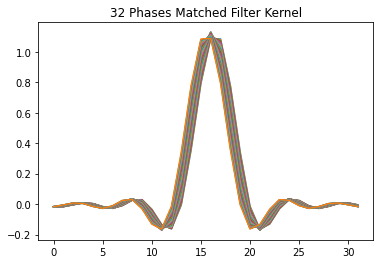

In [4]:
for i in range(32):
    plt.plot(timing_sync_obj.h[i])
plt.title('32 Phases Matched Filter Kernel')
plt.show()

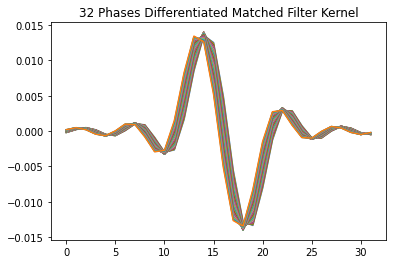

In [5]:
for i in range(32):
    plt.plot(timing_sync_obj.dh[i])
plt.title('32 Phases Differentiated Matched Filter Kernel')
plt.show()

### Calculate the response to the Maximum Likelihood timing error detector

#### High SNR approximaton

Under the high SNR approximation we can approach the maximum likelihood $tanh()$ function with a sign:

$ tanh\left(\frac{E_b}{N_0} \cdot y(t)\right) \rightarrow sgn\left(y(t)\right) ~~~ as ~~ \frac{E_b}{N_0} \rightarrow \infty $

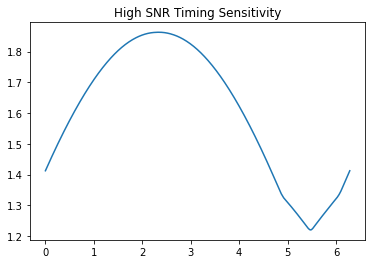

In [6]:
[sensitivity_high, phase] = timing_sync_obj.sensitivity(high_snr=True)

plt.plot(phase, sensitivity_high)
plt.title('High SNR Timing Sensitivity')
plt.show()

#### Low SNR approximaton

Under the low SNR approximation we can approach the maximum likelihood $tanh()$ function by removing it:

$ tanh\left(\frac{E_b}{N_0} \cdot y(t)\right) \rightarrow y(t) ~~~ as ~~ \frac{E_b}{N_0} \rightarrow 0 $

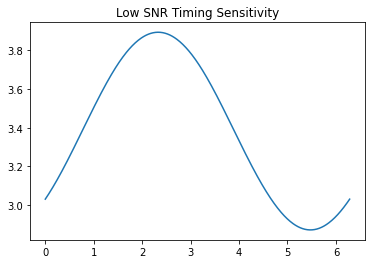

In [7]:
[sensitivity_low, phase] = timing_sync_obj.sensitivity(high_snr=False)

plt.plot(phase, sensitivity_low)
plt.title('Low SNR Timing Sensitivity')
plt.show()

### Loop Dynamics and Stability
To design an optimal timing synchronisation block the loop stability must be considered.

#### Open Loop Transfer Function
The analysis is performed for a type 2 phase locked loop with an excess delay of 1.

The open loop transfer function is:

$$ H_{ol} = \frac{2 \pi k_{pd}}{M} \frac{z K_p + K_i-Kp}{z {(z-1)}^2} $$

So the pole and zeros can easily be determined:

poles:  $z=0$,   $z=1$,   $z=1$

zeros:  $z=1 - \frac{K_i}{K_p}$

#### Stability Margins
We will aim for a phase margin of $60^\circ$. To calculate the required gains define the loop magnitude frequency response:

$$ |H(\omega)| = K \frac{\sqrt{{\left( cos (\omega) + \frac{K_i}{K_p} - 1 \right)}^2 + sin^2 (\omega) }}{{(cos (\omega) -1)}^2 + sin^2 (\omega)} $$

The phase response:

$$ \angle H(\omega) = tan^{-1} \left( \frac{1 - \frac{K_i}{K_p} - cos (\omega)}{sin \omega} \right) - 2 \cdot tan^{-1} \left( \frac{1 - cos (\omega)}{sin (\omega)} \right) + \omega - \frac{\pi}{2}$$

/home/tom/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/home/tom/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
/home/tom/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


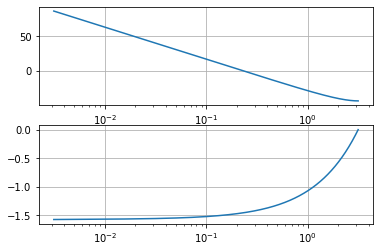

In [63]:

def H_mag(w, K, Ki, Kp):
    
    if Ki == 0:
        num = 1
        den = 1 + np.sqrt((np.cos(w)-1)**2 + np.sin(w)**2)
    else:
        num = np.sqrt( (np.cos(w) + Ki/Kp - 1)**2 + np.sin(w)**2 )
        den = (np.cos(w)-1)**2 + np.sin(w)**2
    return 20*np.log(K * num / den)


def H_ph(w, K, Ki, Kp):
    if Ki == 0:
        return -np.arctan((1-np.cos(w))/np.sin(w))+w-np.pi/2
    else:
        return np.arctan((1-Ki/Kp-np.cos(w))/np.sin(w))-2*np.arctan((1-np.cos(w))/np.sin(w))+w-np.pi/2
    

Kp = 10.0
Ki = 0.0001
K  = 0.023 * Kp
mag = []
ph  = []
w = np.linspace(0, np.pi, 1000)
for w_i in w:
    mag.append(H_mag(w_i, K, Ki, Kp))
    ph.append( H_ph (w_i, K, Ki, Kp))

plt.subplot(2,1,1)
plt.semilogx(w,mag)
plt.grid()
plt.subplot(2,1,2)
plt.semilogx(w,ph)
plt.grid()
plt.show()

### Create Loop

In [9]:
data_length = 512*8*8
data = [np.random.randint(2) for _ in range(data_length)]
modem_bpsk_obj = GenericModem(  modulation_type = ["129", "QPSK 2/9"],
                                samples_per_symbol = 4,
                                pulse_factor = 0.5,
                                pulse_length = 33,
                                filename = "../library/DVB-S2X_constellations.json")
tx = modem_bpsk_obj.modulate(data)

In [52]:
timing_sync_obj.reset()
rx = []
index = []
error = []
controller_i_sum = []
control_signal = []
for tx_n in phase_shift(tx,0.75):
    rx += timing_sync_obj.update([tx_n + 0.5*(np.random.randn()+1j*np.random.randn())], high_snr=False)
    index.append(timing_sync_obj.controller_phase_index)
    error.append(timing_sync_obj.error)
    controller_i_sum.append(timing_sync_obj.controller_i_sum)
    control_signal.append(timing_sync_obj.control)

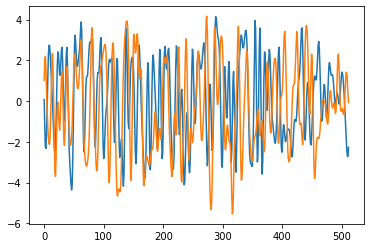

In [53]:
plt.plot(np.real(rx[-512:]))
plt.plot(np.imag(rx[-512:]))
plt.show()

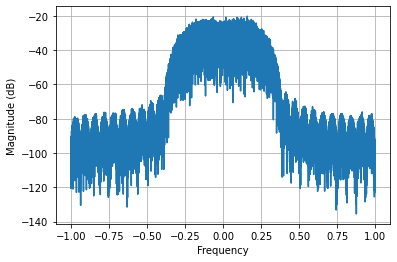

In [54]:
plt.magnitude_spectrum(rx, scale='dB')
plt.grid()
plt.show()

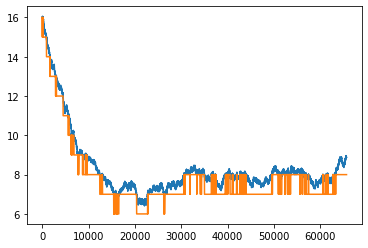

In [55]:
plt.plot(index)
plt.plot([int(_) for _ in index])
plt.show()

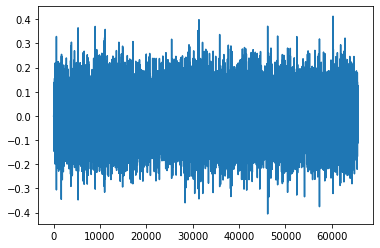

In [56]:
plt.plot(error)
plt.show()

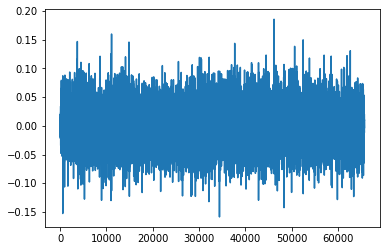

In [57]:
plt.plot(control_signal)   
plt.show()

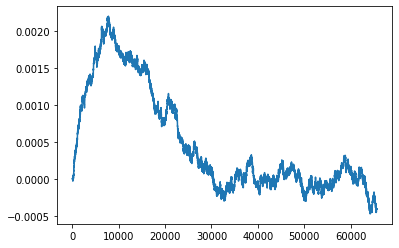

In [58]:
plt.plot(controller_i_sum)
plt.show()

In [59]:
timing_sync_obj.bandwidth()

0.16257860400592614

In [60]:
H_ol = timing_sync_obj.transfer_function()

print(H_ol)
print(H_ol.pole())
print(H_ol.zero())


0.164 z - 0.1639
----------------
z^3 - 2 z^2 + z

[1. 1. 0.]
[0.99951172]


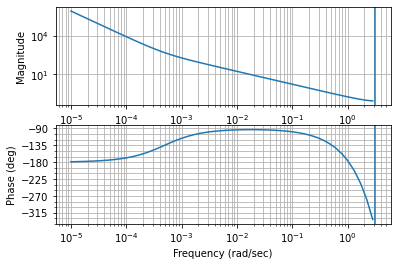

In [61]:
bode = control.bode_plot(H_ol)

Margins
  Gain	:0.000000
  Phase	:62.287262


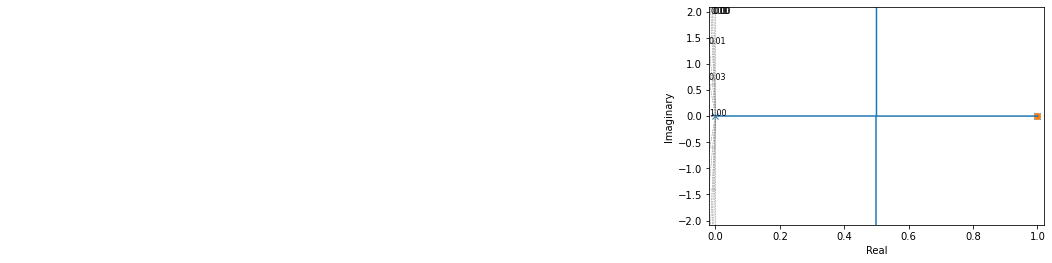

In [62]:
timing_sync_obj.stability(high_snr=False)